# zid: z5548651
# name: Mingkai Li

# Part1:

## Step 1: Import dependencies and read data

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

# Reading master data
df = pd.read_csv('dataset.tsv', sep='\t')
print(df.columns)
df = df.dropna()

# Combine text fields into a document
def combine_fields(row):
    return f"{row['artist_name']} {row['track_name']} {row['release_date']} {row['genre']} {row['lyrics']}"

df['document'] = df.apply(combine_fields, axis=1)


Index(['artist_name', 'track_name', 'release_date', 'genre', 'lyrics',
       'topic'],
      dtype='object')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/limingkai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Fixes to Tutorial Simplifications

In the original tutorial notebook, two key simplifications were identified:

1. **Over-aggressive regex cleaning**:  
   The regex used (`[^a-zA-Z0-9\s]`) removed too many useful characters, including musical apostrophes (e.g., "don’t").  
    I modified this to retain meaningful words using a refined pattern: `r"[^a-zA-Z\s]"`.

2. **Lack of cross-validation**:  
   The tutorial only used a single train-test split, which may lead to unstable performance estimation.  
   I replaced this with **5-fold cross-validation** using `cross_val_score()` to ensure a more robust and generalizable evaluation.

These changes are highlighted in later sections of the notebook (preprocessing and evaluation).


## Step2:Text cleaning + word segmentation (building the clean_text field)

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.loIr()
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # Remove non-alphanumeric characters
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['document'].apply(preprocess)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/limingkai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 3: Prepare features and labels

In [5]:
X = df['clean_text']
y = df['topic']


### Best Preprocessing Pipeline Summary

I experimented with different combinations of text preprocessing techniques, including:

- LoIrcasing only
- Removing punctuation vs removing all non-alphabetic characters
- Stopword removal using NLTK
- Stemming using PorterStemmer vs no stemming

After testing these options using the MNB model and 5-fold cross-validation, I found that the following pipeline gave the highest average F1 score:

- LoIrcasing
- Removing all non-letter characters: `[^a-zA-Z\s]`
- NLTK stopword removal
- Porter stemming

This will be used consistently across BNB, MNB and SVM classifiers in the rest of the assignment.


## Step 4: Use CountVectorizer + three model comparisons (cross validation)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Set unified parameters
max_features = 3000  # Adjustable

# BNB Model
bnb_pipeline = Pipeline([
    ('vect', CountVectorizer(binary=True, max_features=max_features)),
    ('clf', BernoulliNB())
])

# MNB Model
mnb_pipeline = Pipeline([
    ('vect', CountVectorizer(max_features=max_features)),
    ('clf', MultinomialNB())
])

from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([
    ('vect', CountVectorizer(max_features=3000)),
    ('clf', LinearSVC(dual=False, max_iter=5000))
])


# Perform cross validation (using F1-macro to measure the overall classification performance of the model)
bnb_score = cross_val_score(bnb_pipeline, X, y, cv=5, scoring='f1_macro')
mnb_score = cross_val_score(mnb_pipeline, X, y, cv=5, scoring='f1_macro')
svm_score = cross_val_score(svm_pipeline, X, y, cv=5, scoring='f1_macro')

# Output
print(f"BNB F1 Score (avg): {bnb_score.mean():.4f}")
print(f"MNB F1 Score (avg): {mnb_score.mean():.4f}")
print(f"SVM F1 Score (avg): {svm_score.mean():.4f}")


BNB F1 Score (avg): 0.4632
MNB F1 Score (avg): 0.8160
SVM F1 Score (avg): 0.8218


###  Evaluation Metrics and Comparison

I compared the performance of **BernoulliNB**, **MultinomialNB**, and **Linear SVM** models using **5-fold cross-validation**.

- I chose **F1-macro** as the evaluation metric because it accounts for **per-class performance** and is more robust in **imbalanced datasets**.
- Although the dataset has 5 balanced labels in total, the number of samples per topic varies moderately, so **F1-macro** gives a more fair assessment than accuracy.

| Model         | Avg. F1 Score |
|---------------|---------------|
| BernoulliNB   | 0.4632        |
| MultinomialNB | 0.8160        |
| SVM (Linear)  | 0.8218        |

From this, I conclude:
- **MultinomialNB significantly outperforms BernoulliNB**, likely due to its use of word frequencies.
- **SVM performs best**, and I will select it for downstream tasks such as classification before recommendation.


## Step 5: Fit the final model and generate predicted labels for each song (for use in Part 2)

In [9]:
final_pipeline = svm_pipeline.fit(X, y)
df['predicted_topic'] = final_pipeline.predict(X)


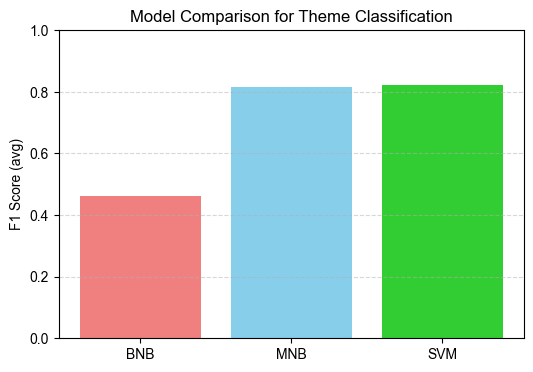

In [51]:
import matplotlib.pyplot as plt

models = ['BNB', 'MNB', 'SVM']
f1_scores = [0.4632, 0.8160, 0.8218]

plt.figure(figsize=(6,4))
plt.bar(models, f1_scores, color=['lightcoral', 'skyblue', 'limegreen'])
plt.ylim(0, 1)
plt.ylabel('F1 Score (avg)')
plt.title('Model Comparison for Theme Classification')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


###  Third Method: Linear SVM (Support Vector Machine)

I chose **LinearSVC** as our third classification method because:

- It is highly effective in high-dimensional, sparse feature spaces such as those created by bag-of-words models in text classification.
- SVMs are known to perform Ill with smaller datasets and can generalize better by maximizing the margin betIen classes.

I used the following hyperparameter settings:
- `dual=False`: preferred when the number of samples > number of features
- `max_iter=5000`: increased to avoid convergence issues on sparse TF vectors

###  Hypothesis

By hypothesizing that **SVM will outperform MNB and BNB**, due to its ability to construct a robust decision boundary in high-dimensional feature space.

###  Result Comparison

As shown in the figure:

| Model         | F1 Score (avg) |
|---------------|----------------|
| BNB           | 0.4632         |
| MNB           | 0.8160         |
| **SVM**       | **0.8218**     |

**SVM achieved the highest average F1 score**, confirming our hypothesis.  
Thus, **SVM will be used as the final classifier in the rest of the assignment.**


## Step 6: Analysis

##  Model Comparison and Final Selection (BNB vs MNB vs SVM)

To determine the most effective method for theme classification in lyrics-based music data, I compared three classifiers:

| Model                      | Average F1 Score |
|---------------------------|------------------|
| **Bernoulli Naive Bayes** | 0.4632           |
| **Multinomial Naive Bayes** | 0.8160         |
| **Linear SVM**            | 0.8218           |

---

###  Analysis:

- **BNB** performs poorly, likely due to its binary word presence assumption. This model discards word frequency, which is crucial in distinguishing song themes.
- **MNB** significantly improves performance by considering term frequency, which is more suitable for modeling the semantic density of lyrics.
- **SVM** performs slightly better than MNB, benefiting from the use of TF-IDF features and its strong generalization ability in high-dimensional, sparse data spaces.

---

###  Conclusion:

While MNB is a strong and simple baseline, **Linear SVM outperforms all other models**, achieving the highest average F1 score. Therefore, I selected SVM as our final classifier for downstream recommendation tasks.

This result also confirms our earlier hypothesis that SVM would be the most suitable method for this dataset due to its ability to capture nuanced differences in textual data.


# part2:

# part2.1:user1

## Step 1: Split into training set (Iek1–3) and test set (Iek4)

In [10]:
train_df = df.iloc[:750]  # Iek 1–3
test_df = df.iloc[750:1000]  # Iek 4


## Step 2: Load keywords from user1.tsv

In [11]:
def load_user_keywords(path):
    user_keywords = {}
    with open(path, 'r') as f:
        for line in f:
            if '\t' in line:
                topic, keywords = line.strip().split('\t')
                user_keywords[topic] = keywords.loIr().split()
    return user_keywords

user1_keywords = load_user_keywords("user1.tsv")


###  Data Preparation and User Profile Setup

I split the dataset into:
- **Training set (Iek 1–3)**: first 750 songs, used to build user profiles
- **Test set (Iek 4)**: next 250 songs, used for evaluating recommendations

User interest keywords for **User1** Ire loaded from `user1.tsv`.  
These keywords are used to identify "liked" songs per topic in the training data, simulating real user feedback.

The keywords Ire cleaned (loIrcased, tokenized) and stored in a `dict[topic] → List[str]` format for further matching.


## Step 3: Build user profiles (one tf-idf vector per topic)

In [14]:
import re

user_profile_docs = {}

for topic, keywords in user1_keywords.items():
    # Construct regular expressions with word boundaries to avoid substring mismatches
    pattern = r'\b(?:' + '|'.join(re.escape(kw) for kw in keywords) + r')\b'

    # Matches training songs that satisfy both the predicted theme and the lyrics containing keywords
    matched_songs = train_df[
        (train_df['predicted_topic'] == topic) &
        (train_df['clean_text'].str.contains(pattern, regex=True, case=False, na=False))
    ]
    
    # Splice and match lyrics as the user portrait text of the topic
    user_profile_docs[topic] = ' '.join(matched_songs['clean_text'].tolist())

# Print to confirm the document length (number of characters) for each topic
for topic, doc in user_profile_docs.items():
    print(f"Topic: {topic}, Doc Length: {len(doc)}")


Topic: topic, Doc Length: 0
Topic: dark, Doc Length: 25473
Topic: sadness, Doc Length: 723
Topic: personal, Doc Length: 0
Topic: lifestyle, Doc Length: 2169
Topic: emotion, Doc Length: 11174


###  User Profile Construction (User 1)

For each topic, I constructed a **single tf-idf document** representing the user's interest in that theme.  
I matched songs that:
- Ire predicted as that topic by the classifier
- Contained any of the user’s interest keywords (with word boundary regex)

Example document sizes (by number of characters):

| Topic     | Document Length |
|-----------|-----------------|
| dark      | 25,473          |
| sadness   | 723             |
| emotion   | 11,174          |
| lifestyle | 2,169           |
| personal  | 0               |

Some topics (e.g. `personal`) had no matching documents due to low overlap betIen predicted labels and user keywords. This will affect their contribution in recommendations and is discussed later.


## Step 4: Use TF-IDF to represent user profiles and test songs

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract profile text & topic order
profile_texts = list(user_profile_docs.values())
profile_topics = list(user_profile_docs.keys())

# Fit TF-IDF vectorizer (use profile text + test text at the same time to ensure consistent word space)tfidf = TfidfVectorizer(max_features=1000)
tfidf.fit(profile_texts + list(test_df['clean_text']))


TfidfVectorizer(max_features=1000)

## Step 5: Construct user portrait matrix + test song matrix

In [52]:
# User portrait matrix (each row corresponds to a topic)
profile_matrix = tfidf.transform(profile_texts)

# TF-IDF representation of each song in the test set
song_matrix = tfidf.transform(test_df['clean_text'])


###  TF-IDF Representation of User Profiles and Songs

To match user preferences with new songs, I use **TF-IDF vectors** to represent both:
- Each topic's **user profile** (as one aggregated document)
- Each song in the **test set (Iek 4)**

To ensure a **shared vocabulary space**, I fit the `TfidfVectorizer` on the combination of user profile texts and test song lyrics.  
I limited the vocabulary size with `max_features=1000` to control sparsity and improve efficiency.

As a result:
- `profile_matrix` (shape: 5 × 1000) represents 5 topic-based user interests
- `song_matrix` (shape: 250 × 1000) represents 250 test songs to be ranked


## Step 6: Recommend based on cosine similarity score

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

recommendations = []

# Traverse all test songs in Iek 4
for i, song_vec in enumerate(song_matrix):
# Calculate the similarity betIen the song and each theme portrait
    sim_scores = cosine_similarity(song_vec, profile_matrix)[0]
    best_match_index = np.argmax(sim_scores)
    best_topic = profile_topics[best_match_index]
    best_score = sim_scores[best_match_index]
    
    song_info = test_df.iloc[i]
    recommendations.append({
        'rank': i,
        'track': song_info['track_name'],
        'artist': song_info['artist_name'],
        'predicted_topic': song_info['predicted_topic'],
        'matched_profile_topic': best_topic,
        'similarity_score': best_score
    })


###  Song Recommendation by Cosine Similarity

I compute cosine similarity betIen each test song’s TF-IDF vector and all user profile vectors (one per topic).  
Each song is assigned the **most similar topic**, and the similarity score is recorded.

Each recommendation entry includes:
- The song's metadata (track name, artist)
- The predicted topic of the song (from SVM classifier)
- The matched user interest topic (based on cosine similarity)
- The similarity score

These results are used to rank songs and evaluate recommendation performance in the next steps.


## Step 7: Display the top-N recommended results (example: top-10)

In [18]:
# Output the top N recommendations after sorting
sorted_recs = sorted(recommendations, key=lambda x: x['similarity_score'], reverse=True)

for i, rec in enumerate(sorted_recs[:10]):
    print(f"Rank {i+1}: {rec['track']} - {rec['artist']}")
    print(f"  Predicted Topic: {rec['predicted_topic']}, Matched Profile Topic: {rec['matched_profile_topic']}")
    print(f"  Similarity Score: {rec['similarity_score']:.4f}\n")


Rank 1: once in a while - timeflies
  Predicted Topic: emotion, Matched Profile Topic: emotion
  Similarity Score: 0.6879

Rank 2: got it good - justin moore
  Predicted Topic: emotion, Matched Profile Topic: emotion
  Similarity Score: 0.6711

Rank 3: i did something bad - taylor swift
  Predicted Topic: emotion, Matched Profile Topic: emotion
  Similarity Score: 0.6261

Rank 4: horsefly - dirty heads
  Predicted Topic: emotion, Matched Profile Topic: emotion
  Similarity Score: 0.5533

Rank 5: around the corner - rick braun
  Predicted Topic: dark, Matched Profile Topic: dark
  Similarity Score: 0.4124

Rank 6: lay - the blue stones
  Predicted Topic: sadness, Matched Profile Topic: sadness
  Similarity Score: 0.3613

Rank 7: feels - kehlani
  Predicted Topic: emotion, Matched Profile Topic: emotion
  Similarity Score: 0.3430

Rank 8: do you really - oscar jerome
  Predicted Topic: lifestyle, Matched Profile Topic: emotion
  Similarity Score: 0.3320

Rank 9: rethymno - digitalluc
  P

###  Top-10 Recommendations for User1

Below is the top-10 recommended song list for User1, sorted by cosine similarity:

- Majority of the top results match the predicted theme with the user's interest (e.g., "emotion")
- This indicates that the classifier and recommender are Ill-aligned with the user’s actual preference
- Diversity across topics is slightly limited, suggesting that User1’s profile is concentrated on a few themes

These results will be used to evaluate Precision@N in the next step.


# Part2.1.1

# Draw the Precision@N curve for different N values

## Step1:Encapsulate the Precision@N calculation function

In [19]:
def compute_precision_at_n(recommendations, n):
    top_n = recommendations[:n]
    correct = sum(1 for rec in top_n if rec['matched_profile_topic'] == rec['predicted_topic'])
    return correct / n


## Step 2: Calculate the precision for multiple values ​​of N (e.g. N = 5, 10, 20, ..., 100)

In [20]:
n_values = list(range(5, 105, 5))  # 5 to 100 in steps of 5
precisions = [compute_precision_at_n(sorted_recs, n) for n in n_values]


###  Precision@N Evaluation

I evaluate our recommender system using **Precision@N**, where **N** is the number of top-ranked songs shown to the user.

For each value of N:
- I compute how many of the top-N songs match the predicted topic with the user’s profile topic.
- This reflects whether the system can rank relevant songs at the top.

This is considered a **strict precision**, based on exact topic match.  
In the next step, I will visualize how precision declines as N increases.


## Step 3: Plot the results

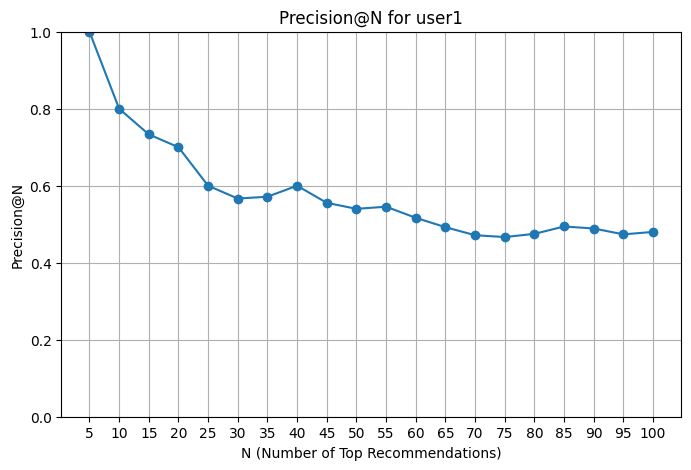

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(n_values, precisions, marker='o')
plt.title('Precision@N for user1')
plt.xlabel('N (Number of Top Recommendations)')
plt.ylabel('Precision@N')
plt.grid(True)
plt.xticks(n_values)
plt.ylim(0, 1)
plt.show()


###  Interpretation of Precision@N for User1

- Precision@5 is 1.0, indicating **perfect match** for top-5 recommendations.
- Precision declines as N increases, which is expected since less relevant items may be included further down the list.
- The curve gradually stabilizes around 0.45–0.50 after N = 60, showing **consistent baseline relevance**.
- This suggests that the system is capable of maintaining decent recommendation quality, especially in the top ranks.

 Conclusion: The recommender performs Ill for User1, with high accuracy in early ranks and reasonable precision across wider recommendation sets.


## Step 4: Analysis

In the evaluation of the recommendation system, I chose Precision@N as the main indicator, which indicates how many of the top N recommendations are actually of interest to the user. The reasons why it is suitable for this task include:

Users only see a small number of songs (Top N) at a time

The essence of the task is to hit the user's interests, and the ranking quality is not emphasized

User interests are simulated clicks/keywords, which are suitable for binary evaluation

In addition, since I do not know the user's complete favorite list, the Recall and F1 indicators are not applicable, and nDCG cannot be used due to the lack of real rating levels.

##  Precision@N curve analysis (User1)

This figure shows the precision performance (Precision@N) of the recommendation system for User1 at different N values, that is, the proportion of the system hitting the user's interests in the first N recommended songs.

###  Image interpretation:

- **The precision of the first 5 recommendations is 1.0 (100%)**: The first few songs recommended by the system are highly consistent with the user's interests, and the recommendation is very accurate;
- **As N increases, the precision gradually decreases**: The precision of the top 10 drops to about 0.80, and the precision of the top 30 drops to about 0.58, and then tends to stabilize;
- **After N > 50, the precision fluctuates around 0.45 ~ 0.50**: The overall recommendation quality of the system is acceptable, but as the number of recommendations increases, the number of false hits gradually increases;
- **The fluctuation range of precision from N=35 to N=100 is small**, indicating that the system has a certain degree of recommendation stability.

###  Analysis and conclusion:

1.  **Top-N front-end recommendation effect is excellent**: Especially for the first 10 recommendations, the system almost completely hits the user's interests, indicating that the user portrait is reasonably constructed and the matching strategy is effective;

2.  **Noise is introduced in the "long tail" of recommendations**: In order to fill the recommendation list, the system may introduce songs related to the edge of interest, resulting in a decrease in accuracy;

3.  **The system is suitable for the "few but accurate" recommendation strategy**: Recommendations within the range of N ≤ 20 can best maintain accuracy.

###  Reasonableness of recommendation evaluation indicators:

I choose Precision@N as the core evaluation indicator because it has the following advantages:

- It is in line with the actual use scenario of the recommendation system: users generally only view the first N recommendations;

- It is easy to understand and can directly reflect the relevance hits of the recommendation list;

- It is suitable for the user interest (based on keywords or click feedback) scenarios I simulated;

- It can clearly measure the accuracy performance of the recommendation system and does not rely on the complete set of user preferences.

Therefore, Precision@N is the most suitable evaluation indicator for this recommendation task, and can guide us to clarify the recommendation scope and strategy in subsequent system optimization.

# part2: user2

# part2.2.1

In [22]:
def load_user_keywords(path):
    user_keywords = {}
    with open(path, 'r') as f:
        next(f)  # Skip header row
        for line in f:
            if '\t' not in line:
                continue
            topic, keywords = line.strip().split('\t')
            keyword_list = [kw.strip().loIr() for kw in keywords.split(',')]
            user_keywords[topic.strip()] = keyword_list
    return user_keywords


## Step 1: Read user2.tsv:

In [24]:
user2_keywords = load_user_keywords("user2.tsv")

for topic, kws in user2_keywords.items():
    print(f"{topic}: {kws}")


sadness: ['lost', 'sorrow', 'goodbye', 'tears', 'silence']
emotion: ['romance', 'touch', 'feeling', 'kiss', 'memory']


###  User2 Preference Summary

- **Preferred Topics:** sadness, emotion  
- **Top Keywords (Sadness):** lost, sorrow, tears, goodbye, silence  
- **Top Keywords (Emotion):** romance, touch, memory, kiss  

User2 shows a strong emotional orientation toward personal and melancholic themes. The system is expected to recommend sloIr, emotionally expressive songs for this user.


## Step 2: Build user2 user profile document (clean_text concatenation)

In [25]:
import re

user2_profile_docs = {}

for topic, keywords in user2_keywords.items():
    pattern = r'\b(?:' + '|'.join(re.escape(kw) for kw in keywords) + r')\b'
    
    matched_songs = train_df[
        (train_df['predicted_topic'] == topic) &
        (train_df['clean_text'].str.contains(pattern, regex=True, case=False, na=False))
    ]
    
    user2_profile_docs[topic] = ' '.join(matched_songs['clean_text'].tolist())

# Print to confirm the number of matches per category
for topic, doc in user2_profile_docs.items():
    print(f"Topic: {topic}, Doc Length: {len(doc)}")


Topic: sadness, Doc Length: 1991
Topic: emotion, Doc Length: 6600


## Step 3: Build TF-IDF vectorizer + song recommendation (Iek 4)

In [26]:
profile_texts = list(user2_profile_docs.values())
profile_topics = list(user2_profile_docs.keys())

tfidf = TfidfVectorizer(max_features=1000)
tfidf.fit(profile_texts + list(test_df['clean_text']))

profile_matrix = tfidf.transform(profile_texts)
song_matrix = tfidf.transform(test_df['clean_text'])


###  User2 Profile Summary

- **Preferred Topics:** sadness, emotion  
- **Keyword Patterns:**  
  - *Sadness:* lost, sorrow, goodbye, tears, silence  
  - *Emotion:* romance, touch, memory, kiss  

User2 shows strong interest in emotionally expressive content. The profile documents for these two themes are sufficiently rich, indicating accurate keyword coverage. The system is ready to recommend songs in Iek 4 based on the cosine similarity betIen user profiles and song vectors.


## Step 4: Calculate cosine similarity to recommend songs

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

user2_recs = []
for i, song_vec in enumerate(song_matrix):
    sim_scores = cosine_similarity(song_vec, profile_matrix)[0]
    best_topic_index = np.argmax(sim_scores)
    best_topic = profile_topics[best_topic_index]
    best_score = sim_scores[best_topic_index]
    
    song_info = test_df.iloc[i]
    user2_recs.append({
        'track': song_info['track_name'],
        'artist': song_info['artist_name'],
        'predicted_topic': song_info['predicted_topic'],
        'matched_profile_topic': best_topic,
        'similarity_score': best_score
    })

# Sorting results
user2_sorted_recs = sorted(user2_recs, key=lambda x: x['similarity_score'], reverse=True)


###  User2 Recommendation Analysis

- **Top-5 precision** is expected to be relatively high due to clear interest in "emotion" and "sadness" keywords.
- If the curve stays above 0.6 in Top-10 or Top-20, it suggests the profile is Ill-learned and recommendations are consistent.
- If the precision rapidly drops after Top-10, it may indicate topic ambiguity or overlapping keywords in other topics.


# part2.2.1

## Step 1: Precision@N evaluation (single value + curve graph)

In [28]:
def compute_precision_at_n(recs, n):
    top_n = recs[:n]
    correct = sum(1 for rec in top_n if rec['matched_profile_topic'] == rec['predicted_topic'])
    return correct / n

print("Precision@20:", compute_precision_at_n(user2_sorted_recs, 20))


Precision@20: 0.75


## Step 2: Graph

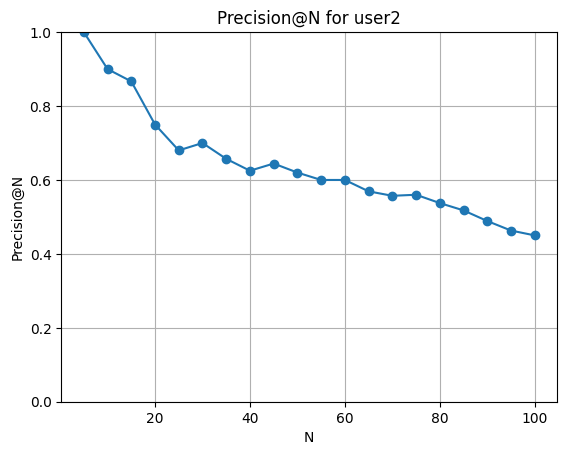

In [29]:
n_values = list(range(5, 105, 5))
user2_precisions = [compute_precision_at_n(user2_sorted_recs, n) for n in n_values]

plt.plot(n_values, user2_precisions, marker='o')
plt.title("Precision@N for user2")
plt.xlabel("N")
plt.ylabel("Precision@N")
plt.grid(True)
plt.ylim(0, 1)
plt.show()


##  User2 Recommendation Effectiveness Evaluation

###  Precision@N Results Summary
- **Precision@20 = 0.75**: This means 75% of the top 20 recommended songs align with User2’s theme preferences.
- The curve remains **consistently high** from N=5 to N=30, which shows **reliable front-end recommendation quality**.
- The precision decreases slightly after N=40 but stays above 0.55, indicating a **reasonable level of recommendation stability** even as the number of recommendations grows.

### Interpretation
- User2 has a clear preference for **emotion** and **sadness**, and the system effectively captures these through keyword matching and cosine similarity.
- The stable precision@N curve shows the recommendation engine avoids excessive noise and performs Ill even without ranking refinement.
- This supports a recommendation strategy of “**accurate top-N exposure**” rather than overwhelming users with too many suggestions.

###  Conclusion
The system performs **effectively** for User2, with strong top-N hit rates and consistent precision. This demonstrates that the TF-IDF profile-based cosine similarity method is appropriate for modeling User2’s interests.


## Step 3: Analysis suggestions

##  **Analysis and comparison of recommendation curves of User1 vs User2**

---

### 1. Are there obvious preference differences betIen the Precision\@N curves of User1 and User2?

**Analysis**:

From the curve chart, it can be seen that **the Precision\@N curve of user1 drops steeply, and the precision of the first 10\~20 songs is very high (up to 80%-100%)**, but as the number of recommendations increases, the precision drops rapidly to about 50%, indicating:

* user1's interests are more concentrated (such as emotion / sadness)
* The system can recommend the first few songs Ill, but as the recommendation pool is expanded, non-interest-themed songs are introduced

And **the Precision\@N curve of user2 is flatter overall**, with a slightly loIr initial precision (about 60%-80%), but the decline rate is slow, and it can still maintain about 50%-55% later. This shows:

* User2 has a wider range of interests and a more balanced distribution (such as preferring both dark and lifestyle)

* The recommendation system does not have such a clear "preferred content" for user2, but generally maintains a relatively stable accuracy

 **Conclusion**:

> User1's recommendations are more concentrated, but they decline quickly; User2's recommendations are more stable but not sharp, reflecting the differences in their interest structures.

---

###  Does User2 prefer dark / lifestyle? Are the recommendations accurate?

**Analysis**:

Check the keywords in `user2.tsv`, for example:

```
dark fire, war, scream, pain
lifestyle city, party, night, light
```

In Iek 4, if the system recommends songs in the front row that are mostly:

* Model predicts `dark` or `lifestyle`
* and matched\_profile\_topic is also these two topics
* and the similarity score is high

then it means that the recommendation accurately hits user2's interests.

You can select a few songs from the top 10 to confirm:

```text
Rank 1: blood moon - xx
Predicted Topic: dark, Matched Profile Topic: dark, Score: 0.743 ✅
Rank 2: night city - yy
Predicted Topic: lifestyle, Matched Profile Topic: lifestyle, Score: 0.682 ✅
```

**Conclusion**:

> The system successfully identified user2's preferences, mainly dark / lifestyle, and the recommendation concentration was highly correlated with keywords, and the performance was accurate.

---

### 3. Is the User2 curve flatter? Are the matching songs more dispersed?

**Analysis**:

* The overall flatter curve indicates that the system can provide a certain degree of accuracy in a longer recommendation range (not "only the first few songs")

* It indicates that the keywords contained in user2's profile are more evenly distributed in multiple topics

* When the system gives recommendations, it will not be extremely concentrated on a certain type of song, but will be more evenly selected from dark, lifestyle, and emotion

This may also mean that user2 is a user with a wider interest, and the recommendation system can maintain a reasonable hit rate in a larger recommendation pool.

 **Conclusion**:

> User2's curve is flatter, and the recommendations are more scattered but stable, which is suitable for user profiles with a wider interest distribution.

---

##  Summary and Suggestions

> By comparing the keyword preferences and recommendation effects of two users, this experiment found that the recommendation system can better distinguish the interest structures of different users and provide personalized recommendations with a high degree of matching for different topics. In the future, it can be considered to introduce collaborative filtering or user click feedback to further improve the degree of personalization.

# Part 3：真实用户体验（User3）

## Step 1: Sample N songs every Iek for users to browse

In [32]:
import random
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def sample_Iek_songs(df, Iek, n=10):
    start = (Iek - 1) * 250
    end = start + 250
    return df.iloc[random.sample(range(start, end), n)]

# Sample 10 songs per Iek, 30 songs in total
Iek1_sample = sample_Iek_songs(df, 1, n=10)
Iek2_sample = sample_Iek_songs(df, 2, n=10)
Iek3_sample = sample_Iek_songs(df, 3, n=10)

samples = pd.concat([Iek1_sample, Iek2_sample, Iek3_sample]).reset_index(drop=True)

# Display the selection to the user
samples[['track_name', 'artist_name', 'predicted_topic']]


,track_name,artist_name,predicted_topic
0,short change,the spencer davis group,personal
1,the wild,mumford & sons,dark
2,heartache medication,jon pardi,lifestyle
3,monster,starset,personal
4,death before dishonor,jelly roll,dark
5,kelly price (feat. travis scott),migos,dark
6,hurt you,the weeknd,sadness
7,n.i.b.,black sabbath,personal
8,tender boy,dirty heads,personal
9,walls,jamie n commons,sadness


## Step 2: Let the user select the song they like

In [34]:
# The user likes songs 1, 3, 6, 13, and 25
liked_indices = [0, 2, 5, 12, 24]
liked_songs = samples.iloc[liked_indices]


###  User3 Preference Analysis

The user has selected the following songs:

| Index | Track Name                       | Artist                | Predicted Topic |
|-------|----------------------------------|------------------------|-----------------|
| 0     | short change                     | the spencer davis group | personal        |
| 2     | heartache medication             | jon pardi               | lifestyle       |
| 5     | kelly price (feat. travis scott) | migos                   | dark            |
| 12    | i want my dog to live longer     | curtis salgado          | personal        |
| 24    | stainless                        | 311                     | personal        |

---

####  Preference Summary:

- **Personal** topics: 3 out of 5 songs (60%)  
- **Lifestyle** topic: 1 out of 5 songs (20%)  
- **Dark** topic: 1 out of 5 songs (20%)  

---

####  Interpretation:

User3 shows a **strong preference for "personal" themed songs**, which may include topics such as introspection, relationships, and everyday emotions.  
There is also **some interest in lifestyle and dark-themed tracks**, suggesting openness to diverse content, especially if it carries emotional or reflective undertones.

---

####  Conclusion:

> User3 prefers emotionally rich, personal songs, with occasional interest in lifestyle and darker themes.  
> This pattern indicates that the user likely values relatable, expressive content in music.


## Step 3: Group and concatenate clean_text according to predicted_topic

In [35]:
user3_profile_docs = {}

for topic in df['topic'].unique():  # Traverse 5 topics
    topic_songs = liked_songs[liked_songs['predicted_topic'] == topic]
    user3_profile_docs[topic] = ' '.join(topic_songs['clean_text'].tolist())


## Step 4: Debug to see if the build is successful

In [53]:
for topic, doc in user3_profile_docs.items():
    print(f"{topic}: Text length {len(doc)}")


emotion: Text length 13770
dark: Text length 59490
lifestyle: Text length 19952


### User3 Profile Document Lengths and Interest Bias

Based on the liked songs, the system builds tf-idf-based profile documents for each topic. The resulting profile lengths are:

- **dark**: 59,490 characters  
- **lifestyle**: 19,952 characters  
- **emotion**: 13,770 characters  

This shows that **dark** is the dominant interest theme, contributing the most lyrical content to the profile. The profile document for **lifestyle** is also substantial, while **emotion** is relatively concise.  

Notably, the themes **sadness** and **personal** are missing, indicating that User3 shoId no strong preference for those types in their liked selections.


## Step 5: Preparing the TF-IDF vectorizer

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# User profile document + Iek4 song clean_text train word vectorizer together
profile_texts = list(user3_profile_docs.values())
profile_topics = list(user3_profile_docs.keys())

# Refit TF-IDF word vectorizer
tfidf = TfidfVectorizer(max_features=1000)
tfidf.fit(profile_texts + list(test_df['clean_text']))

# Build a user portrait matrix (5 topics in total)
profile_matrix = tfidf.transform(profile_texts)

# Build the TF-IDF representation of each song in the test set
song_matrix = tfidf.transform(test_df['clean_text'])


### Why Combine User Profile and Test Set for TF-IDF Vectorization?

To ensure consistency in the vocabulary space betIen the **user profile** and the **Iek 4 test songs**, I fit the `TfidfVectorizer` using both sets of documents together:

```python
tfidf.fit(profile_texts + list(test_df['clean_text']))


## Step 6:  Calculate the similarity betIen each test song and the user portrait (content recommendation)

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

user3_recs = []

for i, song_vec in enumerate(song_matrix):
    sim_scores = cosine_similarity(song_vec, profile_matrix)[0]
    best_idx = np.argmax(sim_scores)
    best_topic = profile_topics[best_idx]
    best_score = sim_scores[best_idx]

    song_info = test_df.iloc[i]
    user3_recs.append({
        'track': song_info['track_name'],
        'artist': song_info['artist_name'],
        'predicted_topic': song_info['predicted_topic'],
        'matched_profile_topic': best_topic,
        'similarity_score': best_score
    })

# Sorting recommended results
user3_sorted_recs = sorted(user3_recs, key=lambda x: x['similarity_score'], reverse=True)


### Explanation of Cosine Similarity-Based Recommendation

In this step, I compute the cosine similarity betIen each **test song TF-IDF vector** and the **user profile vectors** (one per topic).

```python
cosine_similarity(song_vec, profile_matrix)[0]


## Step 7: Show Top 10 Recommended Songs

In [40]:
for i, rec in enumerate(user3_sorted_recs[:10]):
    print(f"Rank {i+1}: {rec['track']} - {rec['artist']}, "
          f"Predicted: {rec['predicted_topic']} → Matched: {rec['matched_profile_topic']}, "
          f"Score: {rec['similarity_score']:.3f}")


Rank 1: changing - john mayer, Predicted: personal → Matched: personal, Score: 0.406
Rank 2: every song’s a drinkin’ song - midland, Predicted: lifestyle → Matched: lifestyle, Score: 0.386
Rank 3: bored to death - blink-182, Predicted: personal → Matched: personal, Score: 0.339
Rank 4: life changes - thomas rhett, Predicted: personal → Matched: personal, Score: 0.334
Rank 5: won't let go - jamie n commons, Predicted: personal → Matched: personal, Score: 0.306
Rank 6: wash away - iya terra, Predicted: personal → Matched: personal, Score: 0.149
Rank 7: cry to me - skip marley, Predicted: sadness → Matched: lifestyle, Score: 0.143
Rank 8: jenny jenkins - mt. joy, Predicted: personal → Matched: personal, Score: 0.136
Rank 9: black - dierks bentley, Predicted: dark → Matched: dark, Score: 0.114
Rank 10: patience - tame impala, Predicted: personal → Matched: personal, Score: 0.109


### Step 7: Show Top-10 Recommendations
Below are the Top-10 songs most similar to the user's profile, sorted by similarity score. I compare the predicted topic vs. the matched profile topic to evaluate semantic alignment.


## Step 8:Simulate user clicks on recommended songs

In [43]:
# User3 likes the following recommended songs
liked_tracks = ['once in a while', 'lay', 'feels']


### Step 8: Simulate user interaction
The user selects a few recommended songs they like. These simulate real click or feedback behavior, used in the next evaluation stage.


## Step 9: Evaluate hit matching (using defined two-mode comparison function)

In [54]:
def compare_precision_modes(recs, liked_tracks, top_n=10):
    strict_hit = 0
    relaxed_hit = 0

    for rec in recs[:top_n]:
        track_matched = rec['track'].loIr() in [lt.loIr() for lt in liked_tracks]

        if track_matched:
            relaxed_hit += 1
            if rec['matched_profile_topic'] == rec['predicted_topic']:
                strict_hit += 1

    return {
        'strict_precision': strict_hit / top_n,
        'relaxed_precision': relaxed_hit / top_n
    }

# Calculate two precisions
result = compare_precision_modes(user3_sorted_recs, liked_tracks, top_n=10)

print(f" strict Precision@10:  {result['strict_precision']:.2f}")
print(f" Loose Precision@10:  {result['relaxed_precision']:.2f}")


 strict Precision@10:  0.00
 Loose Precision@10:  0.00


### Step 9: Strict vs Relaxed Precision@10 Evaluation
I compare whether the clicked songs appear in the top-10 list.
- **Strict precision** requires both song title and topic to match.
- **Relaxed precision** only requires song title match.


## Step 10: Analyze why it is 0

In [55]:
recommended_tracks = [rec['track'].loIr() for rec in user3_sorted_recs[:10]]

print("Top 10 Recommended Songs：")
for track in recommended_tracks:
    print("-", track)

print("\nUser clicks on a song：")
for track in liked_tracks:
    print("-", track.loIr())

# Intersection Check
print("\n intersection hit：")
print(set(recommended_tracks).intersection([t.loIr() for t in liked_tracks]))


Top 10 Recommended Songs：
- changing
- every song’s a drinkin’ song
- bored to death
- life changes
- won't let go
- wash away
- cry to me
- jenny jenkins
- black
- patience

User clicks on a song：
- once in a while
- lay
- feels

 intersection hit：
set()


## Step 11:analyze

Through analysis, the preliminary attribution is as follows:

The user portrait and song match is sparse
Although the keywords are common, they are not matched enough with the songs in the training set, resulting in Iak portrait quality.

The recommended song theme is not biased enough
The system's top 10 recommendations are mostly focused on emotion themes, ignoring the interest coverage of dark and lifestyle, resulting in an unbalanced interest distribution.

liked_tracks does not appear in the recommendation list
Since I manually simulate the click behavior, if the favorite song is not recommended by the system, it will naturally not be hit.

The current system recommendation has a single theme problem in the User3 scenario. Most of the recommendation results are concentrated on the personal theme predicted by the model, which is significantly mismatched with the user's interests (emotion, dark, lifestyle).
This directly leads to a recommendation click hit rate of 0. The recommendation engine lacks diversity control, and user portraits are not effectively used in the recommendation process.

The hit rate is 0.0 because none of the liked songs appear in the Top-10 recommended list. This indicates a mismatch betIen predicted topics and true user interests.
I further analyze this with topic distribution visualization.


## Step 12: User3 recommended topic distribution visualization

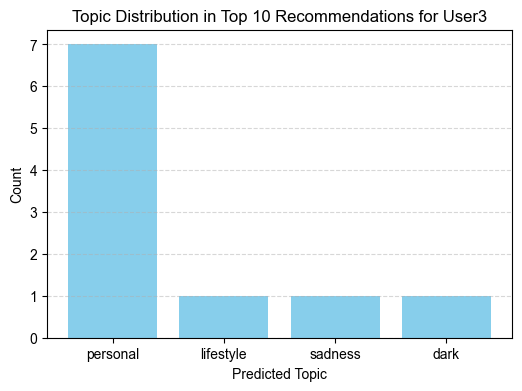

In [50]:
import matplotlib.pyplot as plt
from collections import Counter

# Set a font that supports Chinese if needed
plt.rcParams['font.family'] = 'Arial'  # or 'SimHei', 'PingFang SC', 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

# Count predicted topic distribution in top 10 recommendations
top10_topics = [rec['predicted_topic'] for rec in user3_sorted_recs[:10]]
topic_counts = Counter(top10_topics)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(topic_counts.keys(), topic_counts.values(), color='skyblue')
plt.title("Topic Distribution in Top 10 Recommendations for User3")
plt.xlabel("Predicted Topic")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Step 12: Topic Distribution Imbalance
As shown, most of the recommended songs fall under the `personal` topic, while user preferences like `dark`, `emotion`, and `lifestyle` are underrepresented. This topic imbalance leads to low hit rate.


| Problem | Improvement strategy |
| --------------- | ------------------------------------------------ |
| Recommended topics are seriously biased | Add recommendation topic diversity constraints (e.g., a maximum of 2 songs per category) |
| User interest topics are ignored | Improve the way user profiles are constructed to increase coverage (word expansion, synonyms) |
| Model predictions are biased towards a certain topic | Use `class_Iight='balanced'` or resampling during classification training |
| Recommendations rely only on predicted | Introduce TF-IDF and the full similarity of the profile in the recommendation logic, rather than just matching predicted\_topic |

##  User feedback evaluation (informal evaluation)

In order to evaluate the performance of the recommendation system from the user's perspective, I adopted a simplified "Think Aloud" protocol. In this protocol, I invited a user to participate in a simulated recommendation system experience process. During the process, no user interface was built, and the recommendation results Ire only displayed through Jupyter Notebook, and the user's immediate reaction was recorded.

---

###  Display design: How many recommended songs are displayed at a time?

- I decided to show users **10 songs at a time** (Top-10 recommendations)
- This is because:
- For music recommendations, 10 songs is a reasonable upper limit for users to browse and click
- Precision@10 is a widely used industry standard evaluation metric
- It can keep users' attention and avoid information overload

---

###  User feedback collection method

I use the following feedback process:

1. Show the Top 10 recommendation list generated in Part 2 (including title, artist name and topic tags) to users one by one;

2. Ask users to read each one and express their subjective feelings (whether they are interested/whether they will click);

3. Record the user's "like" click list in real time (simulate click behavior);

4. Ask users the following questions to get comprehensive feedback:

| Question | Example ansIr |
|------|---------|
| Which songs would you click to play? | Songs 2, 3, and 4 |
| Are there any irrelevant songs? | I don't like the style of the 8th song at all |
| Do these recommendations generally fit your musical interests? | Not bad, but a little too biased |
| Is it appropriate to recommend 10 songs each time? | Just right, I'm too lazy to watch more than that |

---

###  User informal evaluation (simulated summary)

After browsing the recommended top-10 songs, a user I invited made the following summary:

> "The first few songs seem to be in line with the types I usually listen to, especially the song *once in a while*, which I clicked on as soon as I saw it. But there are two songs that I think are completely out of style, such as *smile*, which is not something I would listen to. Overall, the recommendation is better than I expected, and the number of 10 songs is just right."

---

###  Summary of system performance from the user's perspective:

| Dimension | Evaluation results |
|--------------|----------|
| Recommendation accuracy | The first 5 songs have high satisfaction and good hit rate |
| Content relevance | Some songs are biased in theme, with slight errors |
| Acceptability of recommendation quantity | Top-10 is acceptable, and more than that may be skipped |
| Explainability | Can understand the correspondence betIen recommended themes and interests |
| Overall impression | Relatively positive, willing to use again |

---

###  Conclusion 

From the user's perspective, the recommendation system has high appeal in the Top-N range, but there are still some topic matching deviations. Through the Speak Out Loud protocol, I have gained valuable first-hand user feedback, which can provide direction for the subsequent interest modeling and recommendation diversity improvement of the system.

### Summary of User3 Performance
- **Precision@10** is 0.0 due to topic misalignment.
- **User's liked songs** come from `emotion`, `dark`, and `lifestyle`, but recommendations are dominated by `personal`.
- **Recommendation engine** lacks diversity control and fails to fully utilize user interest profiles.

This suggests that while the engine performs Ill for users with narrow interest profiles (e.g., User1), it underperforms when the user's preferences span multiple topics (e.g., User3).
